# MNIST Classification

In [1]:
import sys
from microtorch import nn, Tensor
from microtorch.optim import Adam, Optimizer
from microtorch.losses import CrossEntropyLoss
from microtorch.utils.trainer import Trainer
from microtorch.utils.loss_dict import LossDict

import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets.mnist import MNIST


from pathlib import Path

In [2]:
mnist = MNIST(root='./data', train=True, download=True, transform=None)

In [3]:
X_train = mnist.data.float().numpy() / 255
y_train = mnist.targets.numpy()

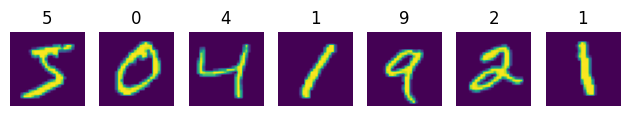

In [4]:
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.axis('off')

plt.tight_layout()

In [5]:
class DataLoader:
    def __init__(self, X, y, batchsize: int = 32, shuffle=False):
        self.X = X
        self.y = y
        self.shuffle = shuffle
        self.batchsize = batchsize

    def __len__(self):
        return len(self.X) // self.batchsize

    def __iter__(self):
        n = len(self.X)
        b = self.batchsize
        idx = np.arange(n)
        if self.shuffle:
            np.random.shuffle(idx)
        for i in range(0, n, b):
            i = idx[i:i+b]
            yield Tensor(self.X[i].reshape(-1, 28**2)), Tensor(self.y[i])

In [6]:
dl = DataLoader(X_train, y_train, batchsize=128, shuffle=True)

In [7]:
class Accuracy(nn.Module):
    def __call__(self, logits: Tensor, targets: Tensor) -> Tensor:
        return Tensor(np.mean(logits.data.argmax(axis=-1) == targets.data))

In [8]:
class MNISTTrainer(Trainer):
    def train_step(self, batch) -> LossDict:
        X, y = batch
        pred = self.model(X)
        loss = self.criterion(pred, y)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return LossDict(loss=loss.data, **self.compute_metrics(pred, y))

In [9]:
model = nn.Sequential(
    nn.Linear(28**2, 512),
    nn.LeakyReLU(),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10)
)

In [10]:
trainer = MNISTTrainer(
    model=model,
    criterion=CrossEntropyLoss(),
    optimizer=Adam(model.params(), lr=0.001),
    metrics={
        'accuracy': Accuracy()
    }
)

In [11]:
trainer.fit(1, dl)

Epoch 1: 469it [00:12, 36.67it/s, accuracy=0.9284, loss=0.2409]                 


In [15]:
X, y = next(iter(dl))
pred = model(X).data.argmax(axis=-1)

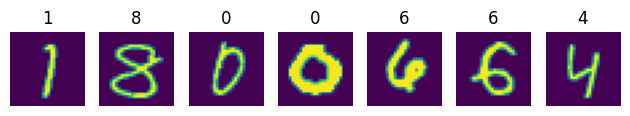

In [16]:
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(X.data[i].reshape(28, 28))
    plt.title(pred.data[i])
    plt.axis('off')

plt.tight_layout()